# 1. Importação de bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Carregamento dos dados

In [2]:
train_data = pd.read_csv('treino.csv')
test_data = pd.read_csv('teste.csv')

# 3. Seleção de colunas e normalização dos dados

In [3]:
past_close_columns = [f'Past_{i}_Days_Close' for i in range(1, 16)]
X_train = train_data[past_close_columns].values
X_test = test_data[past_close_columns].values

# 3.1 RobustScaler com range ajustado

In [4]:
scaler = RobustScaler(quantile_range=(1, 99))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Criação de sequências e aumento de dados

In [5]:
def create_sequences(data, labels, time_steps=15):
    X, y = [], []
    for i in range(time_steps, len(data)):
        sequence = data[i - time_steps:i]
        X.append(sequence)
        y.append(labels[i])

        # Data augmentation melhorada
        if labels[i] == 1:
            # Adiciona ruído gaussiano
            noisy_sequence = sequence + np.random.normal(0, 0.005, sequence.shape)
            X.append(noisy_sequence)
            y.append(labels[i])

            # Time warping
            warped_sequence = sequence * (1 + np.random.uniform(-0.02, 0.02))
            X.append(warped_sequence)
            y.append(labels[i])

            # Amplitude scaling
            scaled_sequence = sequence * np.random.uniform(0.98, 1.02)
            X.append(scaled_sequence)
            y.append(labels[i])

    return np.array(X), np.array(y)

# 4.1 Criação de sequências para treino e teste

In [6]:
X_train_seq, y_train = create_sequences(X_train_scaled, train_data['Label'].values)
X_test_seq, y_test = create_sequences(X_test_scaled, test_data['Label'].values)

# 4.2 Conversão de rótulos

In [7]:
y_train = np.where(y_train == -1, 0, y_train)
y_test = np.where(y_test == -1, 0, y_test)

# 5. Cálculo dos pesos de classe

In [8]:
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0] * 1.2, 1: class_weights[1]}  # Aumento do peso da classe minoritária

# 6. Criação do modelo LSTM aprimorado

In [9]:
def create_model():
    model = Sequential([
        # Primeira camada LSTM com mais unidades
        Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer='l2'),
                     input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        BatchNormalization(),
        Dropout(0.3),

        # Segunda camada LSTM
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer='l2')),
        BatchNormalization(),
        Dropout(0.3),

        # Terceira camada LSTM
        Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer='l2')),
        BatchNormalization(),
        Dropout(0.2),

        # Camadas densas com regularização
        Dense(128, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.1),

        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.0005)  # Learning rate reduzido
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model


# 7. Configuração dos callbacks

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Aumentado
    restore_best_weights=True,
    min_delta=0.0005
)

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Redução mais suave
    patience=8,
    min_lr=0.000001,
    verbose=1
)

In [12]:
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# 8. Treinamento de modelos em ensemble

In [13]:
n_models = 1  # Aumentado número de modelos
models = []

In [ ]:
for i in range(n_models):
    print(f"Training model {i+1}/{n_models}")
    model = create_model()

    # Training with more epochs and smaller batch size
    history = model.fit(
        X_train_seq, y_train,
        epochs=100,  # Aumentado
        batch_size=32,  # Reduzido
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        class_weight=class_weight_dict,
        verbose=1
    )
    models.append(model)

Training model 1/1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.5150 - loss: 16.4883 - val_accuracy: 0.7835 - val_loss: 9.0285 - learning_rate: 5.0000e-04
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 238ms/step - accuracy: 0.5468 - loss: 7.9783 - val_accuracy: 0.5371 - val_loss: 5.4735 - learning_rate: 5.0000e-04
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.6442 - loss: 4.5445 - val_accuracy: 0.6416 - val_loss: 3.3655 - learning_rate: 5.0000e-04
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 236ms/step - accuracy: 0.5973 - loss: 3.6405 - val_accuracy: 0.4509 - val_loss: 3.5113 - learning_rate: 5.0000e-04
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 237ms/step - accuracy: 0.6720 - loss: 2.6814 - val_accuracy: 0.5816 - val_loss: 2.4465 - learning_rate: 5.0000e-04
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.7439 - loss: 2.0233 - val_accuracy: 0.8946 - val_loss: 1.4210 - learning_rate: 5.0000e-04
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━

# 9. Predições em ensemble e otimização de threshold

In [ ]:
y_pred_proba_list = [model.predict(X_test_seq) for model in models]
y_pred_proba_avg = np.mean(y_pred_proba_list, axis=0)

95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step


In [ ]:
thresholds = np.arange(0.3, 0.7, 0.01)
best_threshold = 0.5
best_accuracy = 0

In [ ]:
for threshold in thresholds:
    y_pred_temp = (y_pred_proba_avg > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_temp)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Melhor threshold encontrado: {best_threshold:.3f}")

Melhor threshold encontrado: 0.300


In [ ]:
y_pred = (y_pred_proba_avg > best_threshold).astype(int)

# 10. Avaliação do modelo

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia no conjunto de teste: {test_accuracy:.4f}")


Acurácia no conjunto de teste: 0.9139


In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precisão: 0.9336
Recall: 0.9617
F1-Score: 0.9475


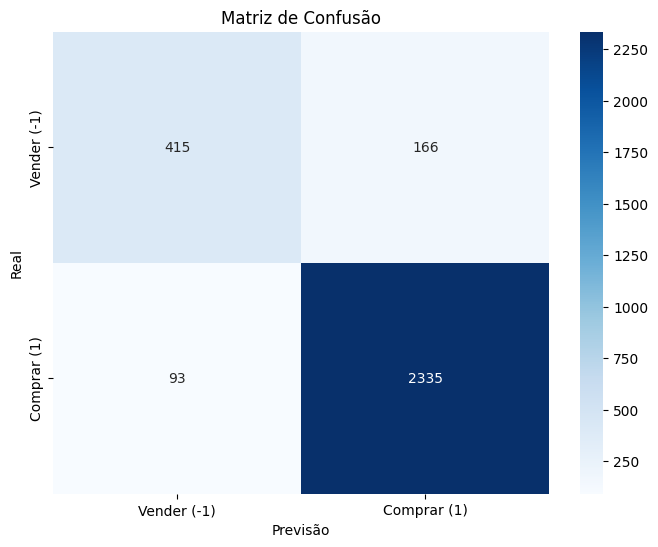

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Vender (-1)', 'Comprar (1)'],
            yticklabels=['Vender (-1)', 'Comprar (1)'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Vender (-1)', 'Comprar (1)']))


Relatório de Classificação:
              precision    recall  f1-score   support

 Vender (-1)       0.82      0.71      0.76       581
 Comprar (1)       0.93      0.96      0.95      2428

    accuracy                           0.91      3009
   macro avg       0.88      0.84      0.85      3009
weighted avg       0.91      0.91      0.91      3009

